In [99]:
import matplotlib.pyplot as plt
import numpy as np
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.interaction import ConversionGainInteraction
from quantum_logical.operators import define_observables
from quantum_logical.trotter import TrotterGroup
from qutip import Qobj, basis, expect, tensor
from scipy.linalg import fractional_matrix_power
from qutip import fidelity

In [100]:
# set up a qutrit in the codespace
# |psi> = 1/sqrt(2) * [|g> + |f>]

# evolve the state using our channels

# apply an iSwap_ee to an ancilla,
# measure the ancilla,
# classically conditioned re-encoding (if we measure a |e>)

# # Define encoded state to be [|g> + |f>]**N
# encoded_state = basis(3, 0) + basis(3, 2)
# encoded_state = encoded_state * encoded_state.dag()
# encoded_state = tensor([encoded_state] * N)
# encoded_state /= encoded_state.norm()
# # two (out of three) qubits from the codeword with ancilla in |g>
# initial_state = tensor(encoded_state.ptrace([0, 1]), basis(d, 0))

In [101]:
q = 1  # Number of qubits (not including ancilla)
N = 2 * q  # numer of total
dim = 3  # hilbert space dim

# Assuming all qubits have the same T1 and T2
T1 = 1
T2 = 1

prep_states = []

for _ in range(q):
    encoded_state = basis(dim, 0) + basis(dim, 2)
    encoded_state /= encoded_state.norm()

    # tensor with ancilla in |g>
    initial_state = tensor(encoded_state, basis(dim, 0))
    initial_state = initial_state * initial_state.dag()
    initial_state /= initial_state.norm()

    prep_states.append(initial_state)

initial_state = tensor(prep_states)
display(initial_state)

observables, observable_labels = define_observables(N, dim, exclude_symmetric=False)

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]]

In [102]:
gc, gg = np.pi / 2, 0
trotter_dt = 0.05
duration = 1.0
H = ConversionGainInteraction(gc, gg, transmon_levels=dim)
iswap = H.construct_U(t=duration)
iswap = Qobj(iswap, dims=[[9], [9]])
iswap = tensor(iswap)
iswap

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

In [103]:
amp_damp_channel = AmplitudeDamping(T1, num_qubits=N, hilbert_space_dim=dim)
phase_damp_channel = PhaseDamping(T1, T2, num_qubits=N, hilbert_space_dim=dim)
trotter = TrotterGroup(
    continuous_operators=[amp_damp_channel, phase_damp_channel],
    trotter_dt=trotter_dt,
)


def propagate_state(rho, duration, unitary=None):
    return trotter.apply(rho, duration, discrete_unitary=unitary)


def propagate_state_noiseless(rho, duration, unitary=None):
    rho = Qobj(rho)
    if unitary is not None:
        unitary = Qobj(unitary)
        unitary.dims = rho.dims
        rho = unitary * rho * unitary.dag()
    return rho

In [104]:
propagate_state(initial_state, duration=0, unitary=iswap)
# propagate_state_noiseless(initial_state, duration=0, unitary=iswap)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0. ]]

In [105]:
def projective_measurement(state, outcome):
    """
    Perform a projective measurement on the ancilla qubit.

    Args:
        state (Qobj): The density matrix of the quantum state.
        outcome (str): The measurement outcome ('g' or 'e').

    Returns:
        Qobj: The updated state after the measurement.
    """
    # Define projectors for |g> and |e>
    P_g = tensor(
        [Qobj(np.identity(dim)) for _ in range(N - 1)]
        + [basis(dim, 0) * basis(dim, 0).dag()]
    )
    P_e = tensor(
        [Qobj(np.identity(dim)) for _ in range(N - 1)]
        + [basis(dim, 1) * basis(dim, 1).dag()]
    )

    # Update dims
    P_g.dims = state.dims
    P_e.dims = state.dims

    # Apply the appropriate projector
    if outcome == "g":
        updated_state = P_g * state * P_g.dag()
    elif outcome == "e":
        updated_state = P_e * state * P_e.dag()
    else:
        raise ValueError("Invalid outcome. Choose 'g' or 'e'.")

    # Renormalize the state
    return updated_state / updated_state.tr()

In [106]:
def execute_experiment_schedule(initial_state, schedule, time_step, noiseless=False):
    """
    Execute a quantum experiment according to a specified schedule.

    Args:
        initial_state (Qobj): The initial quantum state (density matrix) of the system.
        schedule (list of dicts): A list where each item represents a stage in the experiment.
                                  Each stage is a dictionary containing 'type' (e.g., 'idle',
                                  'gate', 'meas'), 'duration' for propagation
                                  and unitary stages, 'gate' for the unitary to be applied, and
                                  'outcome' for the measurement stage.
        time_step (float): The time step size for sampling the state evolution.
        noiseless (bool): If True, the state evolution is noiseless (default: False).

    Returns:
        tuple: A tuple containing:
               - states (list of Qobj): The quantum states at each time step.
               - time_points (list of floats): The corresponding time points for each state.
               - stage_end_times (list of floats): The end times of each stage.
    """

    # Ensure all stage durations are positive
    for stage in schedule:
        if stage["duration"] <= 0:
            raise ValueError("All stage durations must be greater than zero.")

    current_state = initial_state
    states = [initial_state]
    time_points = [0]
    stage_end_times = []  # Store the end times of each stage

    for stage in schedule:
        stage_duration = stage["duration"]
        stage_end_time = time_points[-1] + stage_duration
        stage_end_times.append(stage_end_time)

        if stage["type"] in ["idle", "gate"]:
            steps = int(stage_duration / time_step)
            for step in range(1, steps + 1):
                current_duration = step * time_step
                unitary = None

                if stage["type"] == "gate":
                    # Apply the unitary operator fractionally over the stage duration
                    fractional_duration = current_duration / stage_duration
                    unitary = fractional_matrix_power(
                        stage["unitary"], fractional_duration
                    )

                # Propagate the state for the current duration
                if noiseless:
                    state_at_step = propagate_state_noiseless(
                        initial_state, current_duration, unitary
                    )
                else:
                    state_at_step = propagate_state(
                        initial_state, current_duration, unitary
                    )
                states.append(state_at_step)
                time_points.append(time_points[-1] + time_step)

            # Update the current state at the end of the stage
            current_state = state_at_step

        elif stage["type"] == "meas":
            # Measurement is treated as a single step at the end of its duration
            time_points.append(stage_end_time)  # Add end time of measurement
            current_state = projective_measurement(current_state, stage["outcome"])
            states.append(current_state)

        # Prepare the initial state for the next stage
        initial_state = current_state

    return states, time_points, stage_end_times

In [107]:
def plot_observables_vs_time(
    time_points, states, observables, stage_end_times, schedule
):
    plt.figure(figsize=(10, 6))
    relevant_observables = {}  # Store observables with non-zero values

    for label, obs in observables.items():
        exp_values = [expect(Qobj(obs, dims=state.dims), state) for state in states]
        if not all(value == 0 for value in exp_values):
            relevant_observables[label] = exp_values
            plt.plot(time_points, exp_values, label=label, marker="*")

    # Add vertical lines and annotations for stage transitions
    for i, end_time in enumerate(stage_end_times):
        if i > 0:
            start_time = stage_end_times[i - 1]
        else:
            start_time = 0

        plt.axvline(x=end_time, color="gray", linestyle="--")
        stage_center = (start_time + end_time) / 2

        # Annotate each stage
        if i < len(schedule):
            stage_label = schedule[i]["type"]
            if stage_label == "gate":
                stage_label = "iSWAP"  # Customize as needed

            plt.text(
                stage_center,
                plt.gca().get_ylim()[1],
                stage_label,
                ha="center",
                color="gray",
            )

    plt.xlabel("Time")
    plt.ylabel("Expectation Value")
    plt.title("Observable Expectation Values Over Time", pad=10)
    plt.legend()
    plt.grid(True)
    plt.show()

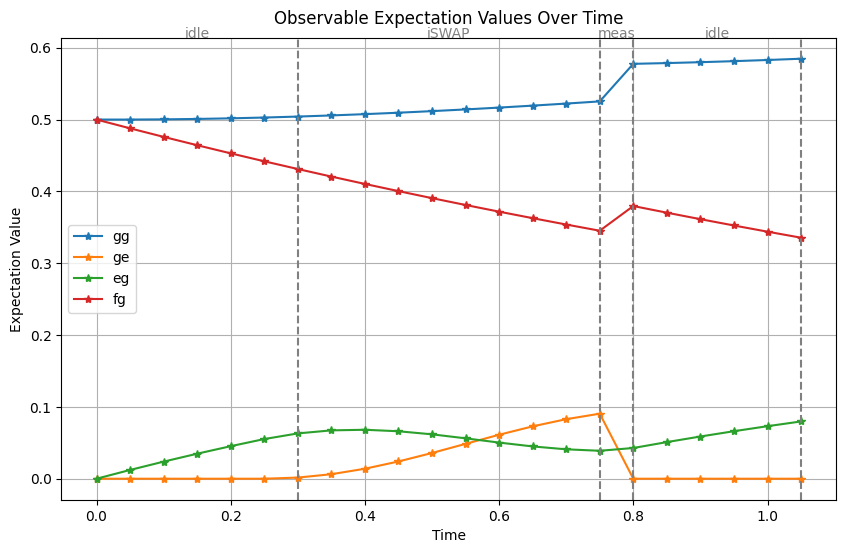

In [108]:
# Define the schedule for the experiment
experiment_schedule = [
    {"type": "idle", "duration": 0.3, "unitary": None},
    {"type": "gate", "duration": 0.5, "unitary": iswap},
    # {"type": "idle", "duration": 0.1, "unitary": None},
    {"type": "meas", "duration": 0.05, "outcome": "g"},
    {"type": "idle", "duration": 0.25, "unitary": None},
]

# Execute the experiment with intermediate sampling
experiment_states, time_points, stage_end_times = execute_experiment_schedule(
    initial_state, experiment_schedule, trotter_dt
)


noiseless_states, _, _ = execute_experiment_schedule(
    initial_state, experiment_schedule, trotter_dt, noiseless=True
)

# Plotting the results
plot_observables_vs_time(
    time_points, experiment_states, observables, stage_end_times, experiment_schedule
)

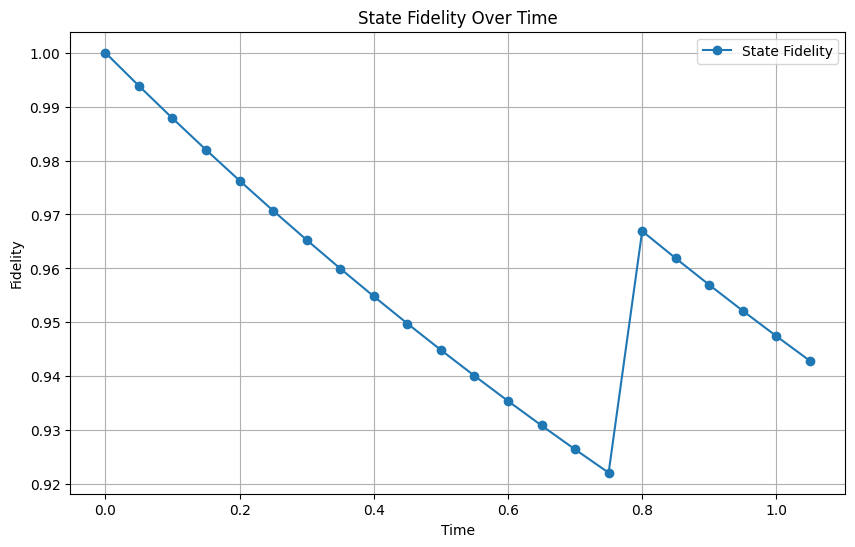

In [110]:
fidelities = []
for noiseless_state, state in zip(noiseless_states, experiment_states):
    fidelities.append(fidelity(noiseless_state, state))
plt.figure(figsize=(10, 6))
plt.plot(time_points, fidelities, label="State Fidelity", marker="o")
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("State Fidelity Over Time")
plt.legend()
plt.grid(True)
plt.show()

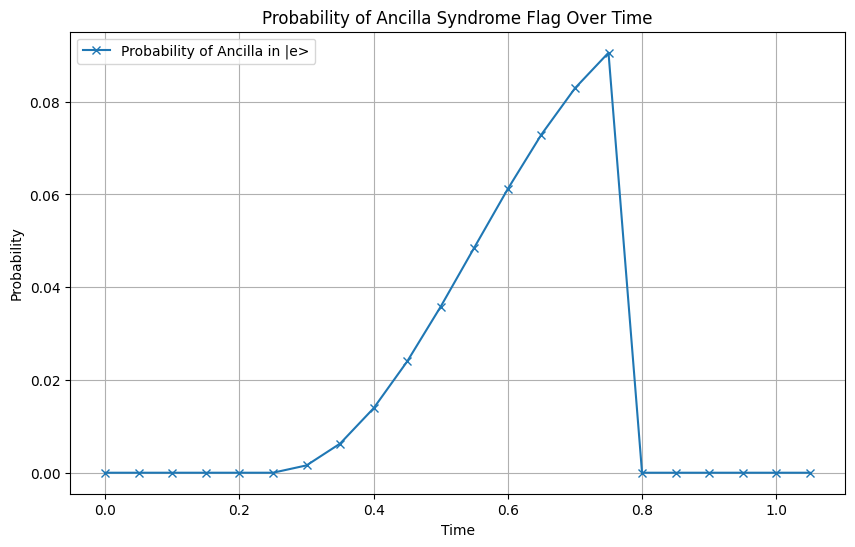

In [112]:
ancilla_probs = []
P_e_ancilla = basis(dim, 1) * basis(dim, 1).dag()

for state in experiment_states:
    # Trace out all qubits except the ancilla
    reduced_state = state.ptrace(N - 1)
    # Calculate the probability of the ancilla being in |e>
    prob_e = (P_e_ancilla * reduced_state).tr()
    ancilla_probs.append(prob_e)
plt.figure(figsize=(10, 6))
plt.plot(time_points, ancilla_probs, label="Probability of Ancilla in |e>", marker="x")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Probability of Ancilla Syndrome Flag Over Time")
plt.legend()
plt.grid(True)
plt.show()